In [4]:
"""
Exercises & Extra-curriculum

See exercises for this notebook here: https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises
"""
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
import random
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import requests
request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import accuracy_fn

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [5]:
"""
5. Load the torchvision.datasets.MNIST() train and test datasets.
"""
train_data = datasets.MNIST(
    root='/home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data', # where to download data to?
    train=True, # do we want the training set? If false will be the test set
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None) # how do we want to transform the labels/targets?

test_data = datasets.MNIST(
    root='/home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40838494.74it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw/train-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1136645.25it/s]

Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9524014.08it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8612354.78it/s]

Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/MNIST/raw



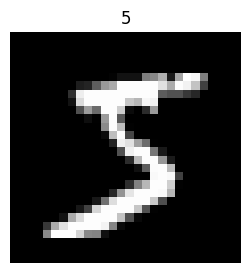

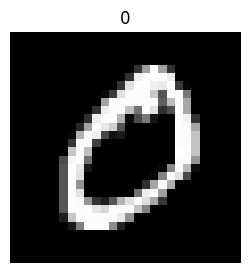

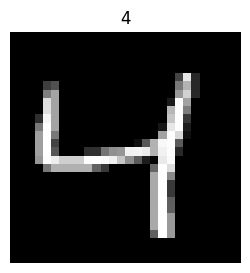

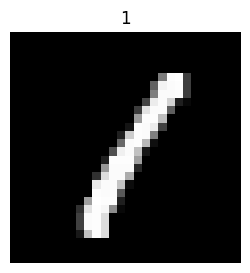

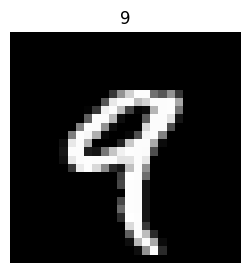

In [6]:
"""
6. Visualize at least 5 different samples of the MNIST training dataset.
"""
for i in range(5):
  img = train_data[i][0]
  img_squeeze = img.squeeze()
  label = train_data[i][1]
  plt.figure(figsize=(3, 3))
  plt.imshow(img_squeeze, cmap="gray")
  plt.title(label)
  plt.axis(False)
  plt.show()

In [7]:
"""
7. Turn the MNIST train and test datasets into dataloaders using
torch.utils.data.DataLoader, set the batch_size=32
"""
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, # which dataset to use
                              batch_size=BATCH_SIZE, # batch size
                              shuffle=True) # if we want the data shuffle every time
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [8]:
"""
8. Recreate model_2 used in this notebook (the same model from the CNN Explainer website,
also known as TinyVGG) capable of fitting on the MNIST dataset.
"""
class MNIST(nn.Module):
    def __init__(self, input_shape:int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape))

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

class_names = train_data.classes
model = MNIST(1, 10, len(class_names))

In [9]:
"""
9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.
"""
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    # Put the model into training mode
    model.train()
    # Add a loop to through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # from logits to prediction labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5.Optimizer step
        optimizer.step()

    # Divide total train loss and acc by lenght of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')

def test_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    # Put the model in eval mode
    model.eval()
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)) # from logits to prediction labels

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n')

model = model.to('cpu')
epochs = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
time_start_cpu = timer()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device='cpu')
    test_step(model=model,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device='cpu')

time_end_cpu = timer()
total_cpu_time = time_end_cpu - time_start_cpu

model_gpu = MNIST(1, 10, len(class_names)).to(device)
epochs = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)
time_start_gpu = timer()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    train_step(model=model_gpu,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_gpu,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

time_end_gpu = timer()
total_gpu_time = time_end_gpu - time_start_gpu

print(f'Time CPU: {total_cpu_time}')
print(f'Time GPU: {total_gpu_time}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.32062 | Train acc: 88.95%
Test loss: 0.07109 | Test acc: 97.58%

Epoch: 1
------
Train loss: 0.07418 | Train acc: 97.67%
Test loss: 0.04839 | Test acc: 98.56%

Epoch: 2
------
Train loss: 0.05717 | Train acc: 98.28%
Test loss: 0.04932 | Test acc: 98.48%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.46655 | Train acc: 83.53%
Test loss: 0.06474 | Test acc: 97.94%

Epoch: 1
------
Train loss: 0.07107 | Train acc: 97.77%
Test loss: 0.04808 | Test acc: 98.40%

Epoch: 2
------
Train loss: 0.05729 | Train acc: 98.18%
Test loss: 0.03907 | Test acc: 98.77%

Time CPU: 154.50155046100002
Time GPU: 41.80362939099996


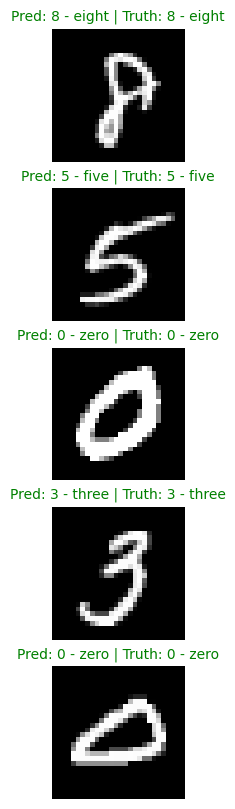

In [10]:
"""
10. Make predictions using your trained model and visualize at least 5
of them comparing the prediciton to the target label.
"""
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model_gpu.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logits = model_gpu(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=5):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model_gpu,
                              data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
plt.figure(figsize=(4, 10))
nrows = 5
ncols = 1
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)
plt.show()

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

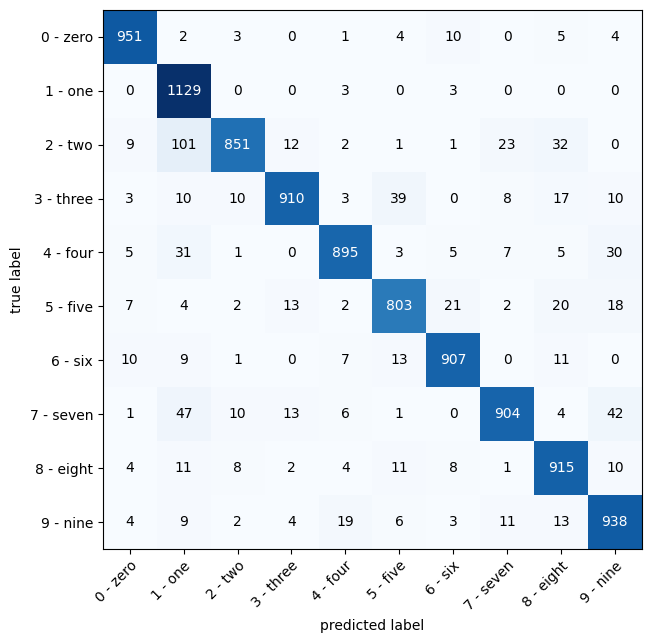

In [13]:
"""
11. Plot a confusion matrix comparing your model's predictions to the truth labels.
"""
y_preds = []
model_gpu.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions...'):
        X, y = X.to(device), y.to(device)
        y_logit = model_gpu(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
    y_pred_tensor = torch.cat(y_preds)
    # print(y_pred_tensor, len(y_pred_tensor))

confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))
plt.show()

In [14]:
"""
12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d()
layer with various hyperparameter settings (these can be any settings you choose),
what do you notice if the kernel_size parameter goes up and down?
"""
rand_tensor= torch.rand(1, 3, 64, 64)
conv_layer = nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1)
output = conv_layer(rand_tensor)
print(rand_tensor.shape)
print(conv_layer)
print(output.shape)
# The shape of the width and height changes according to the kernel size, higher it is, lower the height and width

torch.Size([1, 3, 64, 64])
Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
torch.Size([1, 64, 32, 32])


100%|██████████| 26421880/26421880 [00:02<00:00, 12493768.07it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270357.08it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4971907.19it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19210210.85it/s]


Extracting /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data/FashionMNIST/raw



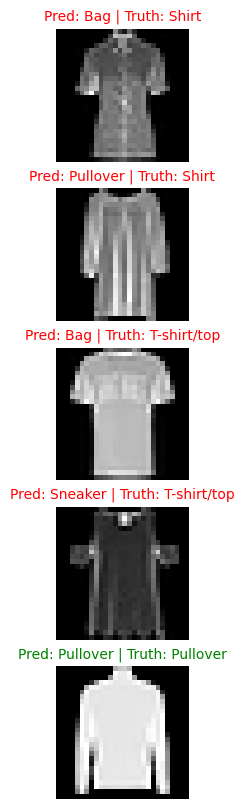

In [15]:
"""
13. Use a model similar to the trained model_2 from this notebook to make predictions
on the test torchvision.datasets.FashionMNIST dataset.
"""
test_data = datasets.FashionMNIST(
    root='/home/michel/Desktop/TopNetwork/08: PyTorch/PYTORCH_NOTEBOOKS/Data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

class_names = test_data.classes

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=5):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model_gpu,
                              data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
plt.figure(figsize=(4, 10))
nrows = 5
ncols = 1
# Then plot some predictions where the model was wrong alongside what the label of the image should've been.
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)
plt.show()

# After visualing these predictions do you think it's more of a modelling error or a data error?
#
# The model isn't performing well because it wasn't train for recognize images of clothing, it's a modelling error


# As in, could the model do better or are the labels of the data too close
# to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?
#
# It could, but it also performs poorly on different types of clothing so is not the case
